In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base = "/Users/lucreziavaleriani/Desktop/orfeo_scratch/utils_locate/simulations_rRACES/out/clonal/sim_21/cov_70_p_0.9"
data = pd.read_csv(base + "/mirr_smooth_snv.csv", sep = ',', on_bad_lines='skip') 

In [4]:
data['pos'] = range(1, len(data) + 1)
data['baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data = data[data['baf']>0]
data_input = {'baf':torch.tensor(np.array(data.baf).reshape(-1, 1)),
            'dr':torch.tensor(np.array(data.median_dr).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.mean_dp).reshape(-1, 1)),
            'orginal_baf':torch.tensor(np.array(data.median_baf).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.vaf).reshape(-1, 1)),
            'dp_snv':torch.tensor(np.array(data.DP).reshape(-1, 1))}

In [5]:
T = data.baf.shape[0]
prior_bp = torch.zeros(T)
prior_bp[[1115, 4464, 4673]] = 1.0       

In [6]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [24]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf":data_input["baf"],
                         "dr":data_input["dr"], 
                         "dp_snp":data_input["dp_snp"], 
                         "vaf": None, 
                         "dp": None})

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "fix_ploidy" : False, 
                         "prior_purity": 0.9,
                         "prior_ploidy": 2.3,
                         "scaling_factors": [1,1,1],
                         'hidden_dim': 4,
                         "prior_bp": prior_bp,
                        "lambda_cn": 1.0,          # ΔCN penalty slope used to shape the prior
                        "alpha_conc": 50.0,        # global Dirichlet concentration (higher = stronger prior)
                        "alpha_self_boost": 3.0,   # extra mass on the diagonal
                        "alpha_dip_boost": 0.5,    # extra mass on diploid column (if present)
                        "bp_strength": 3.0})


In [26]:
ll = locate.run(steps = 100, param_optimizer = {"lr" : 0.05}, guide_kind="normal")

ELBO: -8248.765643897  : 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


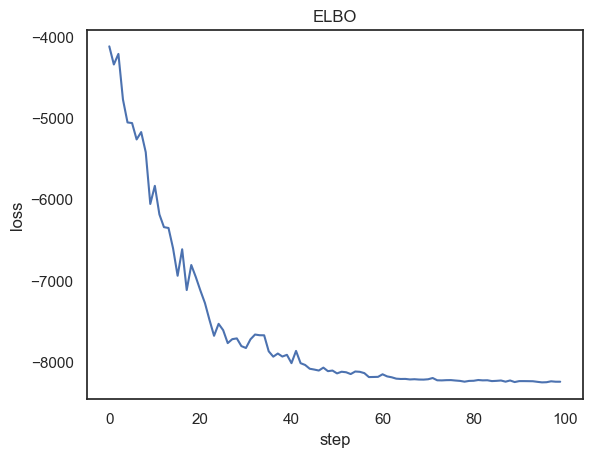

In [27]:
plot_loss(ll[0])

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_purity_ploidy_hist(draws, bins=50):
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    if "purity" in draws:
        axs[0].hist(draws["purity"].numpy(), bins=bins, density=True)
        axs[0].set_title("Posterior of Purity")
    if "ploidy" in draws:
        axs[1].hist(draws["ploidy"].numpy(), bins=bins, density=True)
        axs[1].set_title("Posterior of Ploidy")
    plt.tight_layout(); plt.show()

def plot_totcn_with_uncertainty(totcn_probs, state_map, ylabel="Total CN"):
    T, Cmax1 = totcn_probs.shape
    # expected CN and 95% HPD-ish band (simple equal-tail by cumulative prob)
    cn_vals = np.arange(Cmax1)
    exp_cn = (totcn_probs * cn_vals).sum(axis=1)

    # simple equal-tail 95% interval
    lo = np.zeros(T, dtype=int); hi = np.zeros(T, dtype=int)
    cdf = np.cumsum(totcn_probs, axis=1)
    for t in range(T):
        lo[t] = np.searchsorted(cdf[t], 0.025)
        hi[t] = np.searchsorted(cdf[t], 0.975)

    plt.figure(figsize=(14,3))
    plt.plot(exp_cn, linewidth=1, label="E[Total CN]")
    plt.fill_between(np.arange(T), lo, hi, alpha=0.2, step="mid", label="95% interval")
    plt.step(np.arange(T), state_map, where="mid", linewidth=1.5, label="MAP state (index)")
    plt.ylabel(ylabel); plt.xlabel("Locus index")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_state_heatmap(state_probs):
    plt.figure(figsize=(12,4))
    plt.imshow(state_probs.T, aspect='auto', origin='lower')
    plt.colorbar(label="P(state k | data)")
    plt.ylabel("State index k"); plt.xlabel("Locus index")
    plt.title("Posterior over states per locus"); plt.tight_layout(); plt.show()

In [30]:
params = locate.learned_parameters_Clonal()

In [31]:
# 2) Draw posterior samples
draws = locate.posterior_draws(num_samples=1000, sites=["purity","ploidy","probs_x"])

# 3) Plot purity & ploidy posteriors
plot_purity_ploidy_hist(draws)


RuntimeError: expand(torch.FloatTensor{[1, 1, 9, 9]}, size=[5366, 1, 1]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)
   Trace Shapes:        
    Param Sites:        
   Sample Sites:        
         sp dist   |    
           value 1 |    
     purity dist 1 |    
           value 1 |    
    samples dist   |    
           value 1 |    
mixture_idx dist 1 |    
           value 1 |    
     ploidy dist 1 |    
           value 1 |    
    probs_x dist   | 9 9
           value 1 | 9 9

In [ ]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

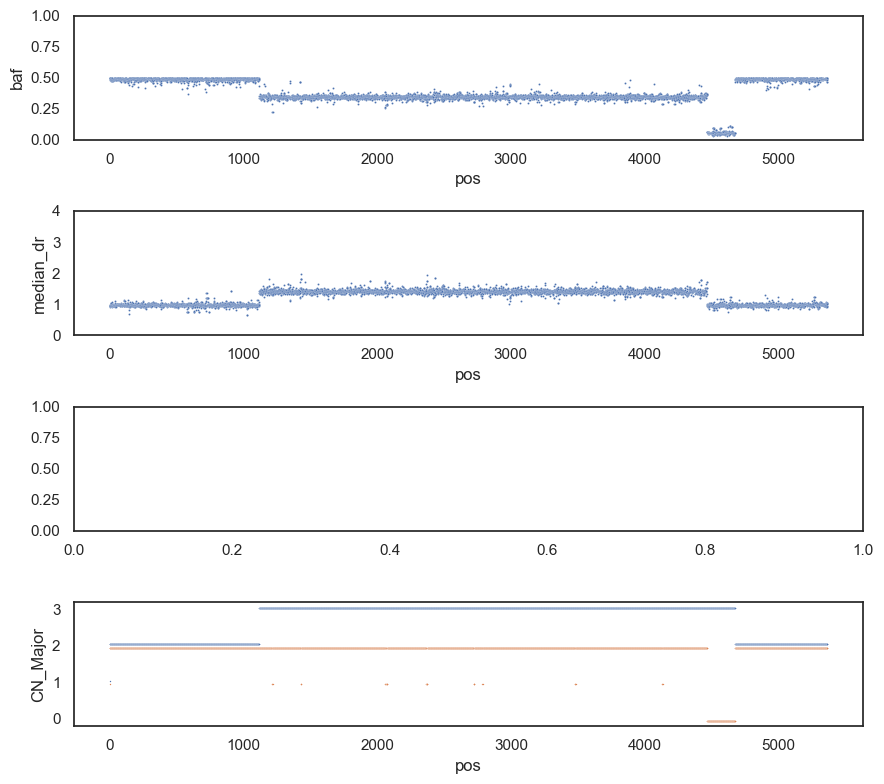

In [ ]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(9, 8))

baf = sns.scatterplot(data=data, x="pos", y="baf", s=2, ax=axes[0])
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1])

cn = sns.scatterplot(data=res, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,4) 
axes[2].set_ylim(0,1) 

fig.tight_layout()